# Imports

In [22]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg
from jaxtyping import Float
import einops
from tqdm.notebook import tqdm
from dataclasses import dataclass

# Model definition

In [2]:
@dataclass
class ModelConfig:
    d_feature: int = 20
    d_model: int = 5
    device: str = "cpu"

In [3]:
class LinearModel(nn.Module):
    def __init__(self, cfg: ModelConfig):
        super().__init__()

        self.cfg = cfg

        d_feature = cfg.d_feature
        d_model = cfg.d_model

        self.W = nn.Parameter(torch.empty(d_feature, d_model))
        # Kaiming initialization works better than Xavier for layers with ReLU activation
        # See https://stats.stackexchange.com/questions/319323/whats-the-difference-between-variance-scaling-initializer-and-xavier-initialize/319849#319849
        nn.init.kaiming_normal_(self.W)
        self.b = nn.Parameter(torch.zeros(d_feature))

    def forward(self, x: Float[Tensor, "batch d_feature"]) -> Float[Tensor, "batch d_feature"]:
        h = einops.einsum(
            x, self.W,
            "batch d_feature, d_feature d_model -> batch d_model"
        )
        out = einops.einsum(
            h, self.W,
            "batch d_model, d_feature d_model -> batch d_feature"
        ) + self.b
        return out

In [4]:
class ReLUModel(nn.Module):
    def __init__(self, cfg: ModelConfig):
        super().__init__()

        self.cfg = cfg

        d_feature = cfg.d_feature
        d_model = cfg.d_model

        self.W = nn.Parameter(torch.empty(d_feature, d_model))
        nn.init.kaiming_normal_(self.W)
        self.b = nn.Parameter(torch.zeros(d_feature))

    def forward(self, x: Float[Tensor, "batch d_feature"]) -> Float[Tensor, "batch d_feature"]:
        h = einops.einsum(
            x, self.W,
            "batch d_feature, d_feature d_model -> batch d_model"
        )
        out = F.relu(
            einops.einsum(
                h, self.W,
                "batch d_model, d_feature d_model -> batch d_feature"
            ) + self.b
        )
        return out

# Data generation

In [5]:
def generate_batch(d_feature: int, batch_size: int, density: float, device: str ='cpu') -> Float[Tensor, "batch_size d_feature"]:
    feat_vals = torch.rand(batch_size, d_feature, device=device)
    feat_probs = torch.rand(batch_size, d_feature, device=device)
    # Add importance, batch and feature dims to densities for broadcasting
    sparsity_mask = feat_probs < density
    # Only those feats with prob < respective density will be present in the generated data
    return feat_vals * sparsity_mask

# Loss function

In [6]:
class ImportanceWeightedMSELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(
            self,
            input: Float[Tensor, "batch_size d_feature"],
            target: Float[Tensor, "batch_size d_feature"],
            importance_decay: float
    ) -> Float[Tensor, ""]:
        d_feature = input.shape[1]
        squared_error = (target - input) ** 2
        # If the initial importance is 0.9 and there are 3 features, the
        # features are importance-weighted as:
        # [1, 0.9, 0.9 ** 2]
        importances = torch.tensor([importance_decay ** i for i in range(d_feature)])
        # Repeat the importances tensor across all batches, e.g.,
        # importances goes from
        # [1, 0.9, 0.9 ** 2]
        # to
        # [[1, 0.9, 0.9 ** 2],
        #  [1, 0.9, 0.9 ** 2]]
        # if there are two batches.
        importances = einops.repeat(importances, "d_feature -> batch_size d_feature", batch_size=input.shape[0])
        per_feature_imse_loss = squared_error * importances
        total_imse_loss = einops.reduce(
            squared_error * importances,
            "batch_size d_feature ->",
            "mean"
        )
        return total_imse_loss

# Training loop

In [7]:
@dataclass
class TrainingArgs:
    lr: float = 1e-3
    n_epochs: int = 10_000
    log_interval: int = 500
    batch_size: int = 1024

In [8]:
def train(
        model: LinearModel | ReLUModel,
        training_args: TrainingArgs,
        optimizer: optim.Optimizer,
        loss_fn: nn.Module,
        density: float,
        importance_decay: float,
        device='cpu'
):
    optimizer = optimizer(model.parameters(), lr=training_args.lr)
    loss_fn = loss_fn()

    epochs = []
    losses = []

    for epoch in tqdm(range(1, training_args.n_epochs + 1)):
        batch = generate_batch(model.cfg.d_feature, training_args.batch_size, density, device)
        loss = (loss_fn(batch, model(batch), importance_decay))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epochs.append(epoch)
        losses.append(loss.item())

        if epoch % training_args.log_interval == 0:
            print(f"Epoch [{epoch}/{training_args.n_epochs}]: loss = {loss.item():.6f}")

    # Plot loss against epochs
    plt.figure(figsize=(5, 3))
    plt.plot(epochs, losses)
    model_type = "Linear" if isinstance(model, LinearModel) else "ReLU"
    plt.title(f'{model_type} model, 1 - S = {density}, Iᵢ = {importance_decay}')
    plt.xlabel('Epoch')
    plt.ylabel('Training loss')
    plt.show()

# Device

In [9]:
# Models typically train in ~30s on CPU in Colab
device = 'cpu'

# Initializing model, density and initial importance

In [17]:
model_cfg = ModelConfig(d_feature=20, d_model=5)
model = ReLUModel(model_cfg)

density = 1
importance_decay = 0.7

# Seed for reproducibility

In [18]:
torch.manual_seed(42)

# Training model

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch [500/10000]: loss = 0.043613
Epoch [1000/10000]: loss = 0.032226
Epoch [1500/10000]: loss = 0.023969
Epoch [2000/10000]: loss = 0.016098
Epoch [2500/10000]: loss = 0.010466
Epoch [3000/10000]: loss = 0.008135
Epoch [3500/10000]: loss = 0.006486
Epoch [4000/10000]: loss = 0.005634
Epoch [4500/10000]: loss = 0.005037
Epoch [5000/10000]: loss = 0.004474
Epoch [5500/10000]: loss = 0.004112
Epoch [6000/10000]: loss = 0.003400
Epoch [6500/10000]: loss = 0.002590
Epoch [7000/10000]: loss = 0.002357
Epoch [7500/10000]: loss = 0.002346
Epoch [8000/10000]: loss = 0.002355
Epoch [8500/10000]: loss = 0.002311
Epoch [9000/10000]: loss = 0.002354
Epoch [9500/10000]: loss = 0.002317
Epoch [10000/10000]: loss = 0.002354


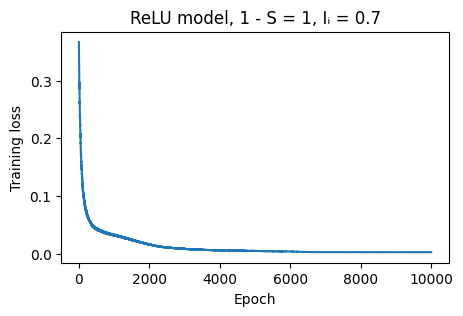

Training complete.


In [19]:
train(model, TrainingArgs(), optim.AdamW, ImportanceWeightedMSELoss, density, importance_decay, device)
print("Training complete.")

# Plotting function

In [20]:
def visualize(model: ReLUModel | LinearModel) -> np.ndarray:
    W = model.W.detach()

    feature_norms = W.norm(dim=1, keepdim=True)
    W_normed = W / (feature_norms + 1e-5)

    self_interactions_mask = (1 - torch.eye(model.cfg.d_feature))
    interferences = ((W_normed @ W.T) * self_interactions_mask) ** 2
    superpositions = interferences.norm(dim=-1)
    superposition_color_mappings = plt.cm.inferno(superpositions)

    fig = Figure(figsize=(3, 7))
    canvas = FigureCanvasAgg(fig)

    # Title figure
    model_type = "Linear" if isinstance(model, LinearModel) else "ReLU"
    fig.suptitle(f"{model_type} model\n1-S = {density:.3f}\n", fontsize=10)

    # WtW plot
    ax1 = fig.add_subplot(2, 1, 1)
    im = ax1.matshow(W @ W.T, cmap='coolwarm', vmin=-1, vmax=1)
    ax1.set_title("WᵀW")

    # Superposition barplot
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.barh(range(model.cfg.d_feature), feature_norms.squeeze().cpu(), color=superposition_color_mappings)
    ax2.set_title("||Wᵢ||")
    ax2.invert_yaxis()

    fig.tight_layout()
    canvas.draw()
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(canvas.get_width_height()[::-1] + (3,))

    return image

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
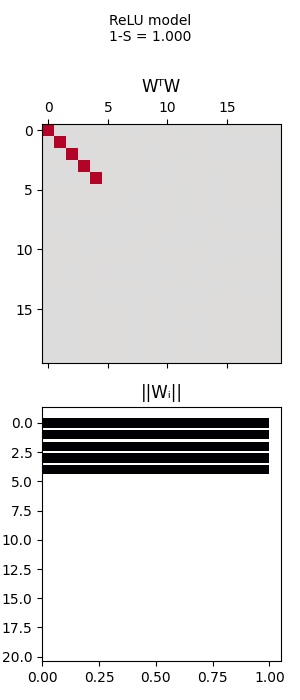

In [21]:
visualize(model)

# Replicating Anthropic's plot

  0%|          | 0/10000 [00:00<?, ?it/s]

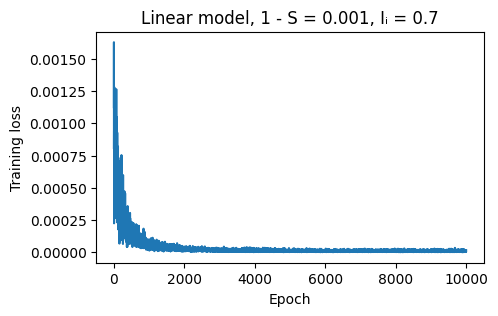

  0%|          | 0/10000 [00:00<?, ?it/s]

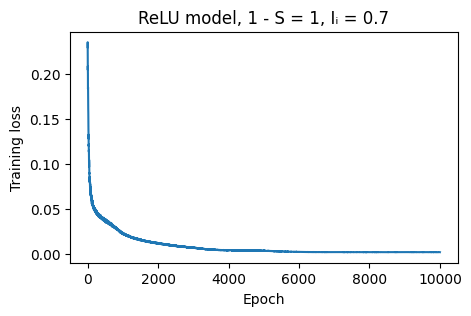

  0%|          | 0/10000 [00:00<?, ?it/s]

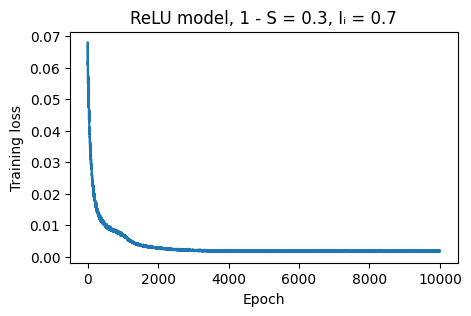

  0%|          | 0/10000 [00:00<?, ?it/s]

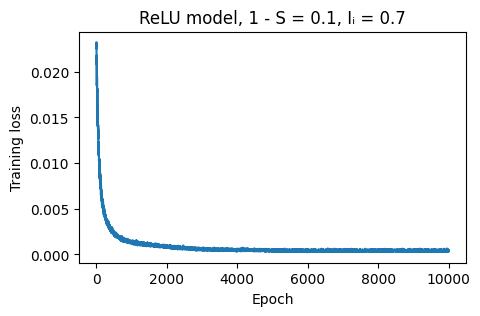

  0%|          | 0/10000 [00:00<?, ?it/s]

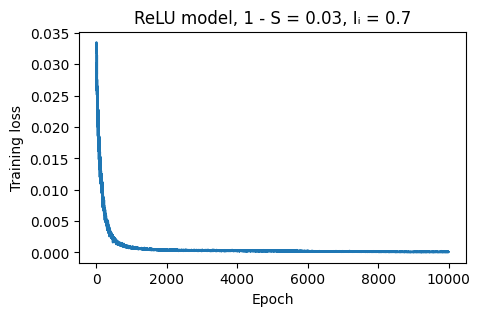

  0%|          | 0/10000 [00:00<?, ?it/s]

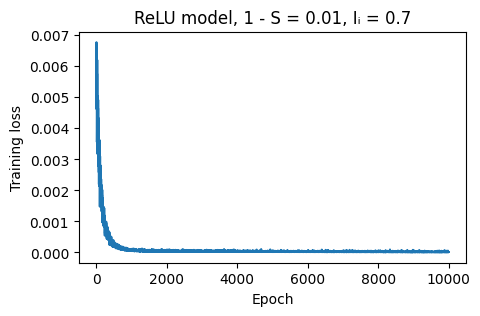

  0%|          | 0/10000 [00:00<?, ?it/s]

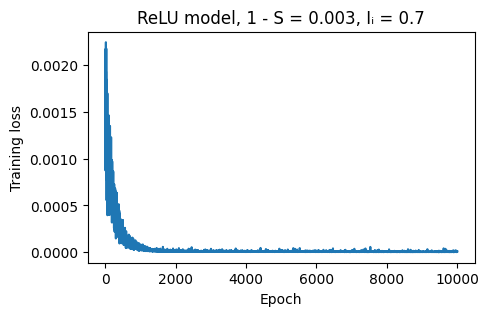

  0%|          | 0/10000 [00:00<?, ?it/s]

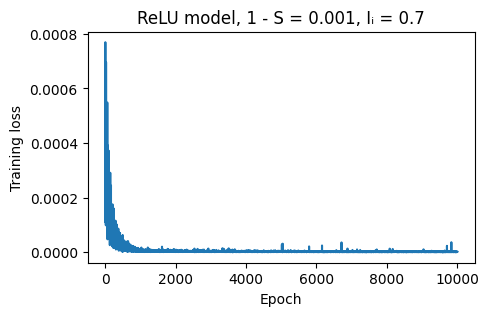

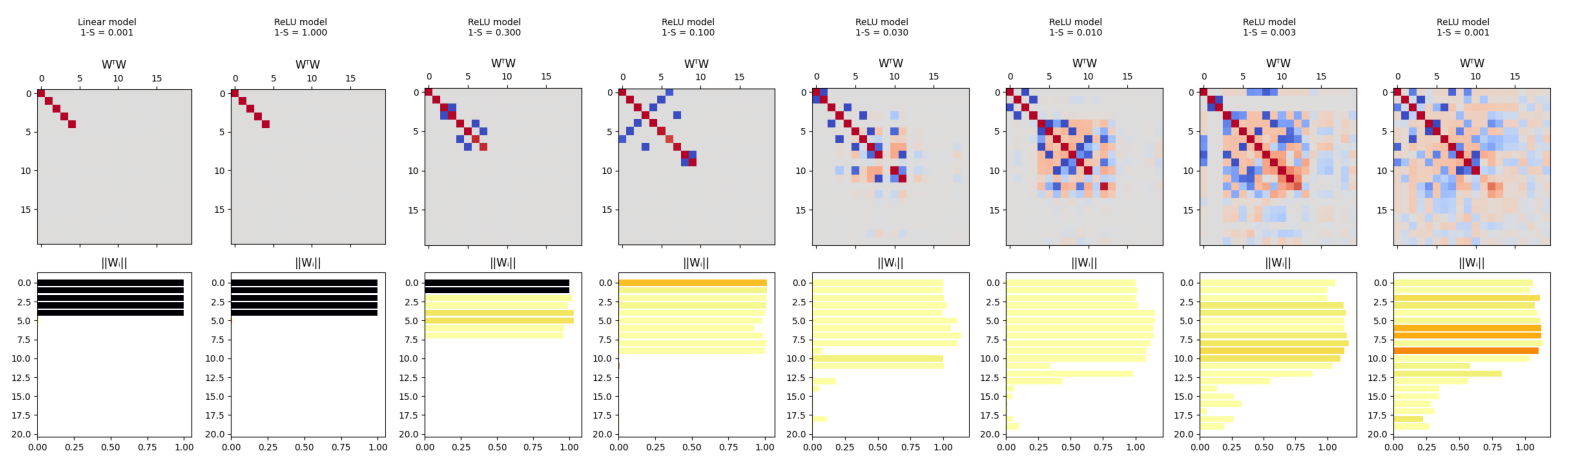

In [16]:
densities = [0.001, 1, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001]
# Except a Linear Model, all models visualized are ReLU
model_classes = [LinearModel] + [ReLUModel] * (len(densities) - 1)
importance_decay = 0.7
model_cfg = ModelConfig(d_feature=20, d_model=5)

columns = []

for model_class, density in zip(model_classes, densities):
    model = model_class(model_cfg)
    # Hackily turning logging off: recall that n_epochs is 10_000 by default
    train(model, TrainingArgs(log_interval=10_001), optim.AdamW, ImportanceWeightedMSELoss, density, importance_decay, device)
    column_image = visualize(model)
    columns.append(column_image)

# Stitch columns together and display
print()
final_plot = np.hstack(columns)
plt.figure(figsize=(20, 6))
plt.imshow(final_plot)
plt.axis('off')
plt.show()